# test tic + peak local max
diles.cdf pour comparer avec les .h5

In [6]:
import numpy as np
import baseline_correction
import math
import h5py
import plot
from read_chroma import read_chromato_and_chromato_cube
import read_chroma
import skimage
import peak_detection
import projection
import netCDF4 as nc

In [22]:
#file_path = '/home/camille/Documents/app/data/G0-1-160123.cdf'
file_path = '/home/camille/Documents/app/data/P-L-007-801838-Tedlar.cdf'
# file_path = '/home/camille/Documents/app/data/A-F-028-817822-droite-ReCIVA.cdf'



In [23]:
def get_mod_time(file_path):
        """Get modulation time based on scan_number from CDF file."""
        #TODO recup  le .npy
        data = nc.Dataset(file_path, 'r')
        scan_number = data.dimensions['scan_number'].size
        if scan_number == 328125:   
            mod_time = 1.25
            print("type de donnees: G0/plasma")
        elif scan_number == 540035:
            mod_time = 1.7
            print("type de donnnees: air expire")
        else:
            print("scan_number non reconnu")
        return mod_time

mod_time= get_mod_time(file_path)

type de donnnees: air expire


In [24]:
def read_chroma(filename, mod_time, max_val=None):
    if not filename.endswith(".cdf"):
        raise ValueError("The file must be a .cdf")

    ds = nc.Dataset(filename, encoding="latin-1")
    tic_chromato = ds['total_intensity']
    abs_point_count = np.abs(ds["point_count"])
    Timepara = ds["scan_acquisition_time"][abs_point_count <
                                           np.iinfo(np.int32).max]
    
    # taux d'échantillonnage : le nombre d'échantillons (points) par unité de temps (par exemple, en Hz).
    sam_rate = 1 / np.mean(Timepara[1:] - Timepara[:-1])
    l1 = math.floor(sam_rate * mod_time)
    l2 = math.floor(len(tic_chromato) / l1)

    if (max_val):
        mv = ds["mass_values"][:max_val]
        iv = ds["intensity_values"][:max_val]
    else:
        mv = ds["mass_values"][:]
        iv = ds["intensity_values"][:]

    range_min = math.ceil(ds["mass_range_min"][:].min())
    range_max = math.floor(ds["mass_range_max"][:].max())

    tic_chromato = np.reshape(tic_chromato[:l1*l2], (l2, l1))

    start_time = ds['scan_acquisition_time'][0] / 60
    end_time = ds['scan_acquisition_time'][-1] / 60

    return (tic_chromato, (start_time, end_time),
            (l1, l2, mv, iv, range_min, range_max))

tic_chromato, time_rn, spectra_obj = read_chroma(file_path, mod_time, None)

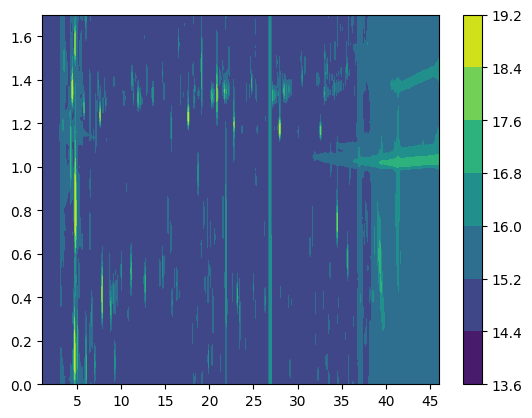

In [25]:
plot.visualizer((tic_chromato, time_rn), mod_time)

In [26]:
tic_chromato_preprocessed = baseline_correction.chromato_reduced_noise(tic_chromato)

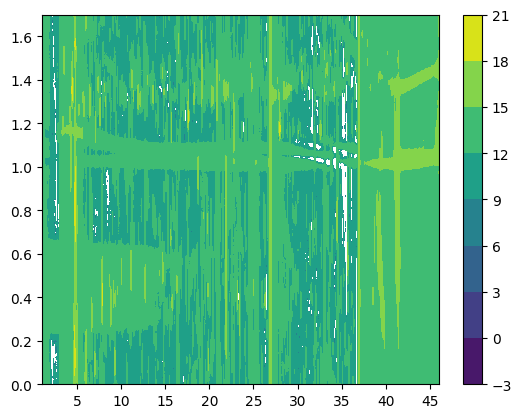

In [27]:
plot.visualizer((tic_chromato_preprocessed, time_rn), mod_time)

In [16]:
sigma = skimage.restoration.estimate_sigma(tic_chromato_preprocessed, channel_axis=None)
print(f"Estimated noise sigma: {sigma}")

Estimated noise sigma: 2672.8120948082405


In [17]:
method = 'peak_local_max'
mode= "tic"
abs_threshold = 0
rel_threshold = 0.01
noise_factor = 1.5
min_persistence = 0.02
min_distance = 1
sigma_ratio = 1.6
num_sigma = 10
min_sigma = 1
max_sigma = 30
overlap = 0.5
match_factor_min = 650
cluster = True
min_samples = 4
eps = 3

In [18]:
coordinates = peak_detection.peak_detection(
    (tic_chromato_preprocessed, time_rn, None),
    chromato_cube=None,
    sigma=sigma,
    noise_factor=noise_factor,
    abs_threshold=abs_threshold,
    rel_threshold=rel_threshold,
    method=method,
    mode=mode,
    cluster=cluster,
    min_distance=min_distance,
    min_sigma=min_sigma,
    max_sigma=max_sigma,
    sigma_ratio=sigma_ratio,
    num_sigma=num_sigma,
    min_persistence=min_persistence,
    overlap=overlap,
    eps=eps,
    min_samples=min_samples)

In [19]:
len(coordinates)

831

In [20]:
coordinates_in_chromato=projection.matrix_to_chromato(coordinates, time_rn, mod_time, tic_chromato_preprocessed.shape)


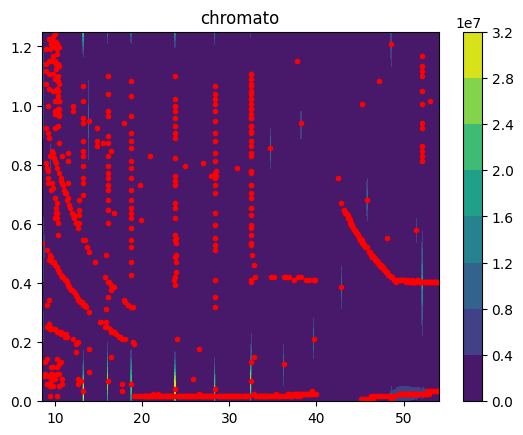

In [21]:
plot.visualizer((tic_chromato_preprocessed, time_rn), mod_time, title="chromato", log_chromato=False, points=coordinates_in_chromato)